PREDICTING CPI MONTH OVER MONTH INFLATION RATE






In [482]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import os
import pickle

import plotly.express as px

In [483]:
with open("fred_key.txt", 'r') as f: FRED_KEY = f.read()

# Querry Data

the following downloads and adjusts macro Indicators that might be able to predict CPI for FRED and varous other websites.

In addition the data gets converted to monthly features and and laged to eliminate data leakage.

CPI data gets released every 2nd Wednesday of the month, so we had to make sure that i cpi (or target variable) was released on the 13.03.21 all the input features (independent varables X) where already available on the 12.03.21

To achive that we need to lag almost all of the variables. Lag values varies between 1 to 5 month.

In [484]:
start_date = '1970'

In [485]:
from fredapi import Fred
fred = Fred(api_key=FRED_KEY)


In [486]:
def change_fred_dtypes(fred_df):
    
    fred_df.dropna(subset=['value'], inplace=True)
    
    fred_df.date = pd.to_datetime(fred_df.date)
    fred_df.realtime_start = pd.to_datetime(fred_df.realtime_start)
    
    fred_df = fred_df.sort_values(['date', 'realtime_start'])
    fred_df = fred_df.drop_duplicates(subset='date', keep='first')
    
    fred_df = fred_df[fred_df.date >= pd.to_datetime('1985')].reset_index(drop=True)
    fred_df.value = fred_df.value.astype(float)
    
    return fred_df

In [487]:
def get_fred_df(fred_id):
    fred_s = fred.get_series(fred_id)
    fred_s.dropna(inplace=True)
    fred_df = pd.DataFrame(fred_s, columns=['value'])
    fred_df.index = pd.to_datetime(fred_df.index)
    fred_df['value'] = fred_df['value'].astype(float)
    
    
    return fred_df
    
    

def get_fred_resample_daily_to_monthly(fred_df):
    """
    get the value for every start of the month and the pct change (log) of the prev start of month to this start of month
    data can then just be merged on index with cpi (release_month) without risk of dataleakage
    
    """

    fred_df['date'] = fred_df.index
    
    
    fred_df = fred_df.resample('M').first()
    fred_df.date = fred_df.date.apply(lambda x: x.replace(day=1))
    fred_df.index = fred_df.date
    
    fred_df['pct_change'] = np.log(fred_df.value).diff()
    
    fred_df.drop('date', axis=1, inplace=True)
    
    return fred_df


def get_yf_df(yf_id):
    import yfinance as yf

    # Set the start and end dates for the historical data
    start_date = "1950-01-01"

    # Download historical data
    df = yf.download(yf_id, start=start_date)

    # Display the first few rows of the data
    df = df[['Adj Close']].rename({'Adj Close': 'value'}, axis=1)
    return df



def get_fred_montly(fred_id, offset=2):

    df = fred.get_series_all_releases(fred_id)
    df = df.dropna(subset='value')
    df.value = df.value.astype(float)
    df = df.drop_duplicates(subset='date', keep='first')
    df.index = pd.to_datetime(df.date)
    df.index += pd.DateOffset(months=offset)
    
    return df

In [488]:
def download_excel(excel_url):
    response = requests.get(excel_url)
    
    
    if response.status_code == 200:
        # Specify the local path to save the Excel file
        local_path = "temp.xlsx"
        # Write the content to a local Excel file
        with open(local_path, 'wb') as file:
            file.write(response.content)

        # Read the Excel file into a Pandas DataFrame
        df = pd.read_excel(local_path)
        print('excel downloaded')

        os.remove(local_path)
    else:
        print(f"Failed to retrieve the file. Status code: {response.status_code}")
    
    return df

In [489]:
def get_manheim_dataset():
    from datetime import datetime, timedelta
    
    # Get the current date
    current_date = datetime.now() - timedelta(days=10)
    
    # Calculate the date one month ago
    one_month_ago = current_date - timedelta(days=30)
    
    # Extract month and year components
    month = current_date.month
    year = current_date.year
    month_prev_str = one_month_ago.strftime("%b")
    year_prev = one_month_ago.year

    print(f'{year}/{month}/{month_prev_str}-{year_prev}')
    
    excel_url = f"https://site.manheim.com/wp-content/uploads/sites/2/{year}/{month}/{month_prev_str}-{year_prev}-ManheimUsedVehicleValueIndex-web-table-data.xlsx"
    
    
    df = download_excel(excel_url)
        
        
    df = df.rename({'Unnamed: 0': 'date', 'Index (1/97 = 100)': 'value'}, axis=1)

    
    df.date = df.date.apply(lambda x: x.replace(day=1))
    
    df.index = df.date
    
    df.index += pd.DateOffset(months=1)
    
    return df

In [490]:
def dowload_china_balence():
    
    excel_url = 'https://www.census.gov/foreign-trade/balance/country.xlsx'
    
    df = download_excel(excel_url)
    
    df = df[df['CTYNAME'] == 'China']
    df = df.drop(['CTYNAME', 'CTY_CODE', 'IYR', 'EYR'], axis=1)

    df = pd.melt(df, id_vars=['year'], var_name='month', value_name='value')

    df['type'] = df.month.str[0]
    df['month'] = df.month.str[1:]

    df['date'] = df['year'].astype(str) + '-' + df['month'].str.lower()

    df['date'] = pd.to_datetime(df.date, format='%Y-%b')

    df = df.pivot(columns='type', values='value', index='date')

    df.columns = ['exports', 'imports']

    df['value'] = df['exports'] - df['imports'] 
    

    return df.replace(0, np.NaN)
    

In [491]:
def dow_jones_industial_average():
    dji_new = get_yf_df('^DJI')
    
    dji_hist = get_yf_df('DJI')
    
    df = pd.concat([dji_hist[dji_hist.index < dji_new.index[0]], dji_new])
    
    df_no_duplicates = df[~df.index.duplicated(keep='first')]
    
    return df_no_duplicates.sort_index()

In [492]:
def quater_to_month(fred_df):
    index = pd.date_range('1960-01-01', '2030-01-01', freq='MS')
    df = pd.DataFrame(None, index=index, columns=['to_drop'])

    return pd.concat([fred_df, df], axis=1).drop('to_drop', axis=1).ffill()

In [493]:
cpi = pd.DataFrame(fred.get_series('CPIAUCSL'), columns=['value'])
cpi = cpi.dropna()
cpi.index = pd.to_datetime(cpi.index)
cpi['cpi_month'] = cpi.index
cpi.index += pd.DateOffset(months=1)

In [494]:
# feature engeneering from cpi data

cpi['cpi_pct'] = np.log(cpi.value).diff()

cpi['month'] = cpi.cpi_month.dt.month
cpi['jan-sep'] = (cpi['month'] <= 9).astype(int)
cpi['oct-dec'] = (cpi['month'] > 9).astype(int)



cpi['cpi_lag1'] = cpi['cpi_pct'].shift(1)
cpi['cpi_3ema'] = cpi['cpi_lag1'] - cpi['cpi_lag1'].ewm(3, min_periods=1).mean()
cpi['cpi_9ema'] = cpi['cpi_lag1'] - cpi['cpi_lag1'].ewm(9, min_periods=1).mean()
cpi['cpi_50ema'] = cpi['cpi_lag1'] - cpi['cpi_lag1'].ewm(50, min_periods=1).mean()

cpi

,value,cpi_month,cpi_pct,month,jan-sep,oct-dec,cpi_lag1,cpi_3ema,cpi_9ema,cpi_50ema
1947-02-01,21.480,1947-01-01,NaN,1,1,0,NaN,NaN,NaN,NaN
1947-03-01,21.620,1947-02-01,0.006497,2,1,0,NaN,NaN,NaN,NaN
1947-04-01,22.000,1947-03-01,0.017424,3,1,0,0.006497,0.000000,0.000000,0.000000
1947-05-01,22.000,1947-04-01,0.000000,4,1,0,0.017424,0.004683,0.005176,0.005409
1947-06-01,21.950,1947-05-01,-0.002275,5,1,0,0.000000,-0.007231,-0.007728,-0.007930
...,...,...,...,...,...,...,...,...,...,...
2023-08-01,304.348,2023-07-01,0.001667,7,1,0,0.001802,-0.000673,-0.001823,-0.001144
2023-09-01,306.269,2023-08-01,0.006292,8,1,0,0.001667,-0.000606,-0.001762,-0.001253
2023-10-01,307.481,2023-09-01,0.003949,9,1,0,0.006292,0.003014,0.002577,0.003306
2023-11-01,307.619,2023-10-01,0.000449,10,0,1,0.003949,0.000504,0.000211,0.000944


<Axes: >

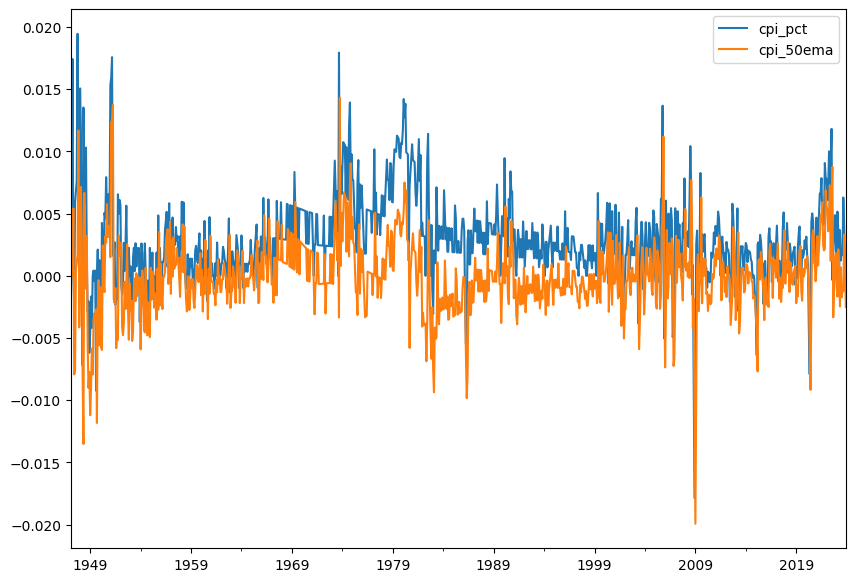

In [495]:
cpi[['cpi_pct', 'cpi_50ema']].plot(figsize=(10, 7))

In [496]:
cpi.corr()

,value,cpi_month,cpi_pct,month,jan-sep,oct-dec,cpi_lag1,cpi_3ema,cpi_9ema,cpi_50ema
value,1.000000,0.975454,-0.109800,0.009020,-0.005303,0.005303,-0.106551,0.003167,0.011904,0.008478
cpi_month,0.975454,1.000000,-0.057241,0.009985,-0.006532,0.006532,-0.056292,0.011677,0.027361,0.040371
cpi_pct,-0.109800,-0.057241,1.000000,-0.029611,0.053677,-0.053677,0.575376,0.257891,0.320634,0.436924
month,0.009020,0.009985,-0.029611,1.000000,-0.751884,0.751884,-0.012305,-0.032748,-0.019700,-0.012253
jan-sep,-0.005303,-0.006532,0.053677,-0.751884,1.000000,-1.000000,0.015794,0.034995,0.024408,0.016919
oct-dec,0.005303,0.006532,-0.053677,0.751884,-1.000000,1.000000,-0.015794,-0.034995,-0.024408,-0.016919
cpi_lag1,-0.106551,-0.056292,0.575376,-0.012305,0.015794,-0.015794,1.000000,0.705925,0.783564,0.879882
cpi_3ema,0.003167,0.011677,0.257891,-0.032748,0.034995,-0.034995,0.705925,1.000000,0.956023,0.829419
cpi_9ema,0.011904,0.027361,0.320634,-0.019700,0.024408,-0.024408,0.783564,0.956023,1.000000,0.927964
cpi_50ema,0.008478,0.040371,0.436924,-0.012253,0.016919,-0.016919,0.879882,0.829419,0.927964,1.000000


<Axes: title={'center': 'CPI Seasonality'}, xlabel='month'>

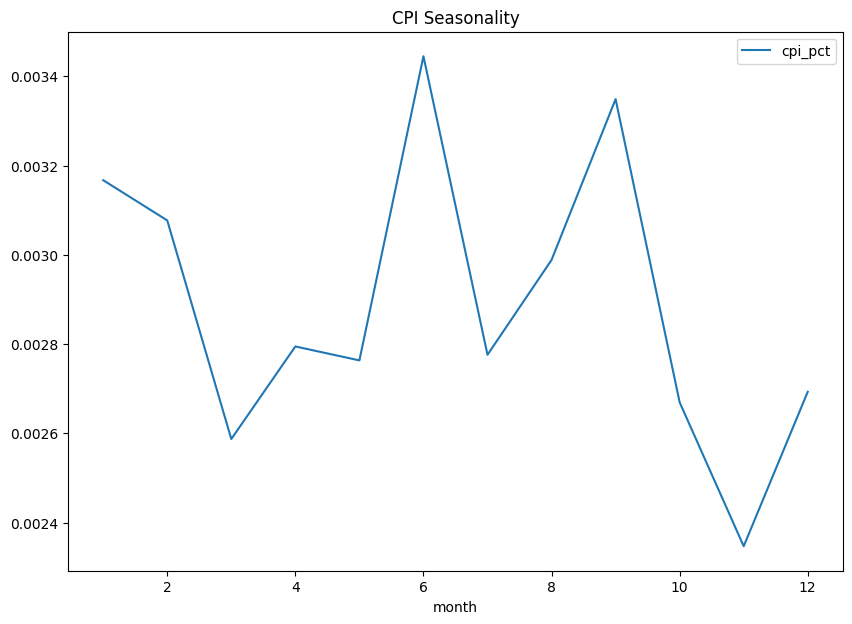

In [497]:
cpi.groupby('month').agg({'cpi_pct': 'mean'}).plot(title='CPI Seasonality', figsize=(10, 7))

In [498]:
data_dict = {}

In [499]:
usd = get_yf_df('DX-Y.NYB')
usd = get_fred_resample_daily_to_monthly(usd)
data_dict['usd'] = usd

[*********************100%%**********************]  1 of 1 completed


In [500]:
wti_raw = get_fred_df('DCOILWTICO')
wti = get_fred_resample_daily_to_monthly(wti_raw)
data_dict['wti'] = wti

In [501]:
gas_raw = get_fred_df('DHHNGSP')
gas = get_fred_resample_daily_to_monthly(gas_raw)
data_dict['gas'] = gas

In [502]:
dji = dow_jones_industial_average()
dji = get_fred_resample_daily_to_monthly(dji)
data_dict['dji'] = dji

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [503]:
ffr_raw = get_fred_df('FEDFUNDS')
ffr = get_fred_resample_daily_to_monthly(ffr_raw)
ffr.index += pd.DateOffset(months=1)
data_dict['ffr'] = ffr

In [504]:
vehic = get_manheim_dataset()
data_dict['vehic'] = vehic

2023/12/Nov-2023
excel downloaded


In [505]:
m2 = get_fred_montly('M2SL', 2)
data_dict['m2'] = m2

In [506]:
m2v = get_fred_montly('M2V', 4)
m2v = quater_to_month(m2v)
data_dict['m2v'] = m2v

In [507]:
chn_trd = dowload_china_balence()
chn_trd.index += pd.DateOffset(months=2)
data_dict['chn_trd'] = chn_trd

excel downloaded


In [508]:
wages = get_fred_montly('LES1252881600Q', 4)
wages = quater_to_month(wages)
data_dict['wages'] = wages

In [509]:
saving = get_fred_montly('PSAVERT', 2)
data_dict['saving'] = saving

In [510]:
pce = get_fred_montly('PCE', 2)
data_dict['pce'] = pce

In [511]:
unemp = get_fred_montly('UNRATE', 1)
data_dict['unemp'] = unemp

In [512]:
i_claims = fred.get_series_all_releases('ICSA')
i_claims.date = pd.to_datetime(i_claims.date)

i_claims.date = i_claims.date.apply(lambda x: x.replace(day=1))
i_claims.drop_duplicates(subset='date', keep='first', inplace=True)
i_claims.index = i_claims.date
i_claims.value = i_claims.value.astype(float)
data_dict['i_claims'] = i_claims

In [513]:
c_claims = fred.get_series_all_releases('CCSA')
c_claims.date = pd.to_datetime(c_claims.date)

c_claims.date = c_claims.date.apply(lambda x: x.replace(day=1))
c_claims.drop_duplicates(subset='date', keep='first', inplace=True)
c_claims.index = c_claims.date
c_claims.index += pd.DateOffset(months=1)
c_claims.value = c_claims.value.astype(float)
data_dict['c_claims'] = c_claims

In [514]:
job_open = get_fred_montly('JTSJOL', 2)
data_dict['job_open'] = job_open

In [515]:
sticky = get_fred_montly('CORESTICKM159SFRBATL', 2)
data_dict['sticky'] = sticky

In [516]:
ppi = get_fred_montly('PPIACO', 2)
data_dict['ppi'] = ppi

In [517]:
copper = get_fred_montly('PCOPPUSDM', 2)
data_dict['copper'] = copper

In [518]:
wheat = get_fred_montly('PWHEAMTUSDM', 2)
data_dict['wheat'] = wheat

In [519]:
housing = get_fred_montly('USSTHPI', 5)
housing = quater_to_month(housing)

data_dict['housing'] = housing

In [520]:
fuel = get_fred_montly('WPU057303', 2)
data_dict['fuel'] = fuel

In [521]:
gov_spending = get_fred_montly('FGEXPND', 4)
gov_spending = quater_to_month(gov_spending)
data_dict['gov_s'] = gov_spending

In [522]:
cur_acc = get_fred_montly('NETFI', 5)
cur_acc = quater_to_month(cur_acc)
data_dict['cur_acc'] = cur_acc

In [523]:
trades = get_fred_montly('BOPGSTB', 2)
data_dict['trades'] = trades

In [524]:
taxes = get_fred_montly('W006RC1Q027SBEA', 5)
taxes = quater_to_month(taxes)
data_dict['taxes'] = taxes

In [525]:
gdp = get_fred_montly('GDP', 4)
gdp = quater_to_month(gdp)
data_dict['gdp'] = gdp

what is the cpi dependent on

Good Data:
oil yes 
gas yes
USD Currency Basket
PPI lagged

Okay Data:
wages  
savings

    
No Data:
food proxy?
wheat 
NFIB
ISM


gov expenditure: FGEXPND
current acc balence: NETFI
trade ballence: BOPGSTB
tax reciepts: W006RC1Q027SBEA
gdp: GDP



consumer confidence

unemployment

CHINA??

supply chains

retail sales

inflation expectations

interest rates/ forward rates

gpd prediction/estimation

used cars (manheim paid)
rent lagged

In [526]:
new_dict = {}
for name, df in data_dict.items():
    new_dict[name] = df['value']
    print(name, len(df))
    if df.index.duplicated().any():
        print(name, 'has duplicated idxs')

usd 636
wti 456
gas 324
dji 648
ffr 833
vehic 323
m2 778
m2v 844
chn_trd 468
wages 841
saving 778
pce 778
unemp 911
i_claims 684
c_claims 684
job_open 275
sticky 672
ppi 1331
copper 526
wheat 526
housing 841
fuel 610
gov_s 896
cur_acc 892
trades 382
taxes 892
gdp 896


In [527]:
features = pd.concat(new_dict, axis=1)

In [528]:
full_dataset = pd.concat([cpi, features], axis=1)

In [529]:
full_dataset = full_dataset[(full_dataset.index > pd.to_datetime(start_date)) & (full_dataset.index < pd.to_datetime('2024'))]

In [530]:
full_dataset.to_csv(f'datasets/raw_data{datetime.now().strftime("%Y-%m-%d")}.csv')

# Plot NaN values Chart

In [531]:
import pandas as pd
import numpy as np
import plotly.express as px


df = full_dataset.copy()

# Create a mask where NaN values are True, and non-NaN values are False
mask = ~df.isna()

# Create a heatmap using Plotly
fig = px.imshow(mask, color_continuous_scale='gray', labels=dict(x='Columns', y='Rows'),
                title='NaN Values (Black) and Non-NaN Values (White)')

fig.update_layout(coloraxis_showscale=False)
fig.update_layout(width=800, height=2000)

# Show the plot
fig.show()

# Missing Value Interpolation

Explanation:
The function takes a time series as input and performs backward interpolation from the first
valid data point up to the earliest available data point in the year 2013.

1. Extract a sub-series from the input series for the years 2013 to 2019.
2. Calculate the mean of the values in this sub-series (vector_2013_2019).
3. Find the first valid index and its corresponding value in the input series.
4. Calculate the time frame between the first valid index and the year 2016.
5. Compute the gradient (rate of change) using the mean value and the first valid value over the time frame.
6. Determine the length of the portion of the series up to the first valid index.
7. Generate interpolated values using the gradient for the determined length.
8. Update the series up to the first valid index with the interpolated values

In [532]:
def interpolate_backward(_series):

    series = _series.copy()
    
    # Extract sub-series for the years 2013 to 2019
    vector_2013_2019 = series[(series.index > pd.to_datetime('2013')) & (series.index < pd.to_datetime('2019'))]
    
    # Calculate mean of the sub-series
    mean_2013_2019 = vector_2013_2019.mean()

    # Find the first valid index and its corresponding value
    first_valid_index = series.first_valid_index()
    first_valid_value = series.loc[first_valid_index]

    # Calculate the time frame between the first valid index and the year 2016 in months
    time_frame = pd.to_datetime('2016') - first_valid_index
    time_frame = time_frame.days / 30.44
    
    # Calculate the gradient (rate of change)
    gradient = (mean_2013_2019 - first_valid_value) / time_frame

    # Determine the length of the portion of the series up to the first valid index
    n = len(series.loc[:first_valid_index])

    # Generate interpolated values using the gradient
    interpolated = np.arange(1, n + 1) * gradient
    interpolated -= interpolated[-1]
    interpolated += first_valid_value

    # Update the series up to the first valid index with the interpolated values
    series.loc[:first_valid_index] = interpolated
    
    return series
        

In [533]:
for nan_col in df.columns[df.isna().any()].tolist():
    df[nan_col] = interpolate_backward(df[nan_col])

<Axes: >

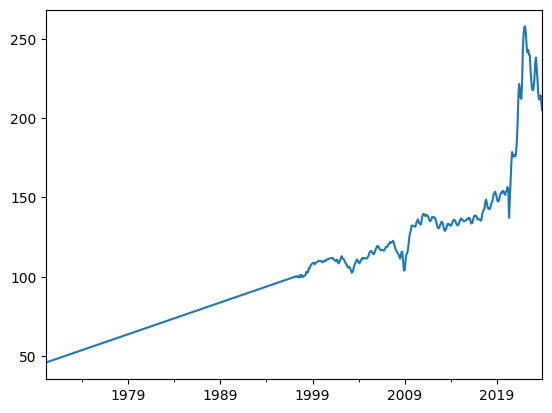

In [534]:
interpolate_backward(full_dataset['vehic']).plot()

## Feature Engineering

To make sure our model can infer anything from our input data, we need to make sure your input features make sense. We cant just input the staationary values of dow jones industrial index for example and explect your model to predict anything.
so we need to do some feature engeneering on the data to make it Stationary and preferably linearly correlated to cpi m/m change which is your target variable.

But we also need to be carful to not overdo it with our feature engeneering. We dont have that high of a sample size (n) with between 400 to 600 samples based on were we choose our cutoff date (somwere between 1970-2000). And if we engineer to many new features it could be that some just correlate with our target varable by chance. 
And no model can filter these random correlations out not even with baysian statistics unsless we set a uninformative prior by hand, which we cant do because it is impossible to know if the correlation is just by chance or not.

Thats why the best solution is to be careful with your feature engineering.


## Feature engennering methods:

1 month, 3 month and 9 month log diffrence
3 month and 9 month log diff laged by 6 and 9 month respectivly
_24ma = cpi_pctt1 - 24m_rolling_pct_change



In [535]:
make_stationary = ['usd', 'wti', 'gas', 'dji', 'ffr', 'vehic', 'm2', 'm2v', 'wages', 'saving', 'pce', 'unemp', 
                'i_claims', 'c_claims', 'job_open', 'sticky', 'ppi', 'copper', 'wheat', 'housing', 
                'fuel', 'gov_s', 'cur_acc', 'trades', 'taxes', 'gdp', 'chn_trd']


keep_non_stationary = ['ffr', 'usd', 'm2v', 'saving', 'unemp', 'i_claims', 'c_claims', 'chn_trd']





In [536]:
# 'chn_trades' needs to be featureengeneered seperatly and the seasonality needs to be taken out take it relative to US gdp
df['chn_trd'] = -df['chn_trd'].rolling(12, min_periods=1).mean() / df['gdp']

In [537]:
for raw_feature in df.loc[:, 'usd':].columns:
    raw_series = df[raw_feature].copy()
    
    if raw_feature in make_stationary:
        if (raw_series <= 0).any(): 
            pct_chg = (raw_series - raw_series.shift(1)).copy()
        else:
            pct_chg = np.log(raw_series).diff().copy()
    
        new_columns = {
            f'{raw_feature}_1m_pct': pct_chg,
            f'{raw_feature}_3m_pct': pct_chg.rolling(3, min_periods=1).sum(),
            f'{raw_feature}_9m_pct': pct_chg.rolling(9, min_periods=1).sum(),
            f'{raw_feature}_3m_pct_6m_lag': pct_chg.rolling(3, min_periods=1).sum().shift(6),
            f'{raw_feature}_9m_pct_9m_lag': pct_chg.rolling(9, min_periods=1).sum().shift(9),
            f'{raw_feature}_24ma': pct_chg - pct_chg.ewm(24, min_periods=1).mean()
        }
    
    df.drop(raw_feature, axis=1, inplace=True)

    df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)
        
    if keep_non_stationary:
        df[f'{raw_feature}_raw'] = raw_series

In [538]:
df = df.dropna()

In [539]:
df.to_pickle(f'datasets/final_dataset_{datetime.now().strftime("%Y-%m-%d")}.pkl')

In [540]:
df = pd.read_pickle(f'datasets/final_dataset_2023-12-18.pkl')

In [541]:
split_pct = 0.25
slice_len = 4

np.random.seed(69)

dflen = len(df)

n_slices = round((dflen * split_pct) / slice_len)

test_index = []
for idx in np.random.choice(np.arange(dflen), size=n_slices):
    idx += 1
    test_index += list(range(idx, min(idx+slice_len, dflen-1)))

test_index = list(set(test_index))

test_index = df.iloc[test_index].index.tolist()
train_index = df.index.difference(test_index).tolist()

train_df = df.loc[train_index]
test_df = df.loc[test_index]

In [542]:
train_df.shape, test_df.shape

((497, 199), (140, 199))

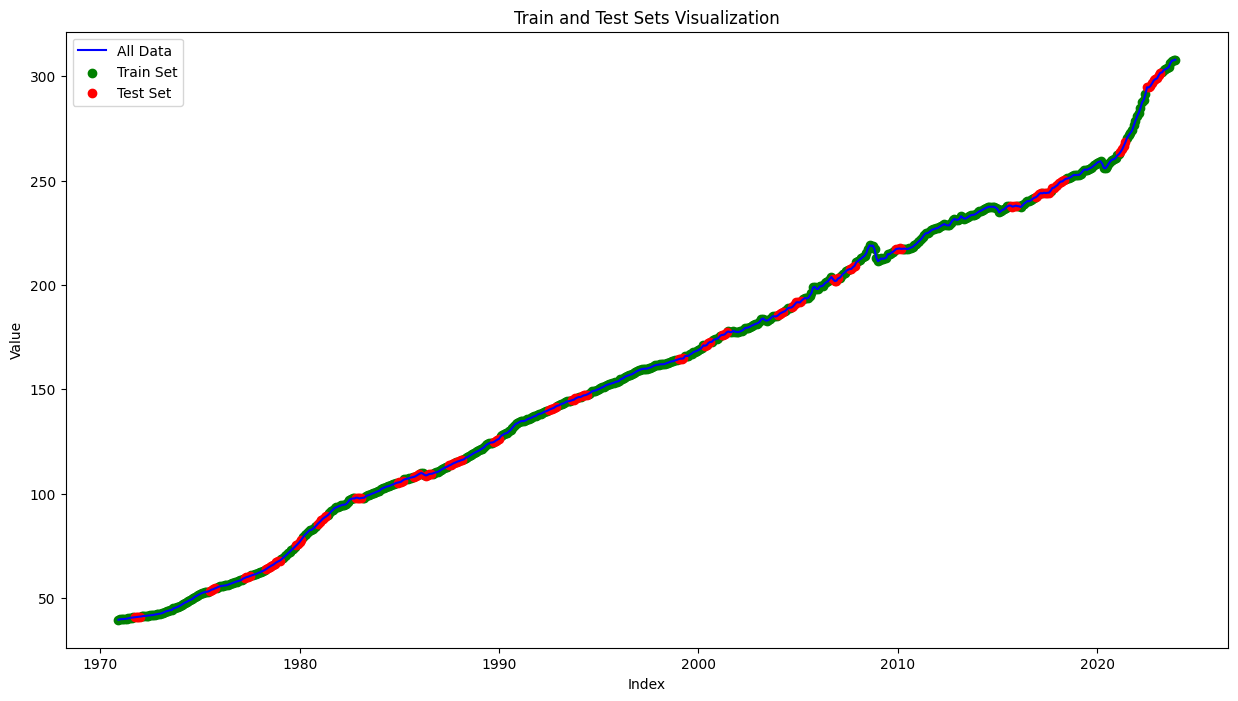

In [543]:
# Plotting
plt.figure(figsize=(15, 8))
plt.plot(df['value'], label='All Data', color='blue')
plt.scatter(train_index, df.loc[train_index, 'value'], label='Train Set', color='green')
plt.scatter(test_index, df.loc[test_index, 'value'], label='Test Set', color='red')
plt.title('Train and Test Sets Visualization')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [544]:
# We save the previous month cpi raw, so we can use is it as benchmark Predictions for our target
test_df[['cpi_lag1']].rename({'cpi_lag1': 'pred'}, axis=1).reset_index(drop=True).to_csv('predictions/benchmark2_prev.csv')

In [545]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_df.loc[:, 'month':] = scaler.fit_transform(train_df.loc[:, 'month':])
test_df.loc[:, 'month':] = scaler.transform(test_df.loc[:, 'month':])

In [546]:
dir_ = 'models/raw_scaler.pkl'
with open(dir_, 'wb') as file:
    pickle.dump(scaler, file)

train_df.to_csv(f'datasets/train_set.csv', index=False)
test_df.to_csv(f'datasets/test_set.csv', index=False)

In [547]:
train_df.describe().round(5)

,value,cpi_month,cpi_pct,month,jan-sep,oct-dec,cpi_lag1,cpi_3ema,cpi_9ema,cpi_50ema,...,taxes_9m_pct_9m_lag,taxes_24ma,taxes_raw,gdp_1m_pct,gdp_3m_pct,gdp_9m_pct,gdp_3m_pct_6m_lag,gdp_9m_pct_9m_lag,gdp_24ma,gdp_raw
count,497.00000,497,497.00000,497.00000,497.00000,497.00000,497.00000,497.00000,497.00000,497.00000,...,497.00000,497.00000,497.00000,497.00000,497.00000,497.00000,497.00000,497.00000,497.00000,497.00000
mean,159.05416,1997-04-28 16:45:23.541247488,0.00318,0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000
min,39.60000,1970-11-01 00:00:00,-0.01786,-1.58859,-1.85405,-0.53936,-6.40457,-6.95822,-7.52447,-6.94940,...,-3.76535,-6.78098,-1.29455,-9.95458,-8.03243,-5.42628,-10.01071,-5.85341,-9.68518,-1.25623
25%,102.60000,1984-02-01 00:00:00,0.00155,-0.99496,0.53936,-0.53936,-0.48199,-0.44392,-0.42915,-0.54765,...,-0.37835,-0.24160,-0.89547,-0.44962,-0.34692,-0.60899,-0.46306,-0.60146,-0.51039,-0.88586
50%,160.40000,1997-07-01 00:00:00,0.00266,-0.10451,0.53936,-0.53936,-0.13828,-0.01748,-0.01555,-0.06147,...,0.14065,-0.15592,-0.07410,-0.44962,-0.07592,-0.05382,-0.14412,-0.05478,-0.34193,-0.23200
75%,219.03500,2010-10-01 00:00:00,0.00461,0.78593,0.53936,-0.53936,0.44466,0.47084,0.47652,0.46272,...,0.58896,0.11215,0.67546,0.43037,0.34375,0.62152,0.40434,0.66139,0.56523,0.75453
max,307.91700,2023-11-01 00:00:00,0.01794,1.67638,0.53936,1.85405,4.47105,5.14250,5.11477,4.97106,...,3.33542,9.04146,3.08479,7.42857,4.83094,3.00831,5.92742,3.24055,7.97153,2.64581
std,71.18925,NaN,0.00333,1.00101,1.00101,1.00101,1.00101,1.00101,1.00101,1.00101,...,1.00101,1.00101,1.00101,1.00101,1.00101,1.00101,1.00101,1.00101,1.00101,1.00101


# PCA Transform

In [548]:
train_df = pd.read_csv(f'datasets/train_set.csv')
test_df = pd.read_csv(f'datasets/test_set.csv')

In [549]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [550]:
pca = PCA()

In [551]:
train_df.loc[:, 'month':].shape, test_df.loc[:, 'month':].shape, 

((497, 196), (140, 196))

In [552]:
train_pca = pca.fit_transform(train_df.loc[:, 'month':])
test_pca = pca.transform(test_df.loc[:, 'month':])


dir_ = 'models/pca_model.pkl'
with open(dir_, 'wb') as file:
    pickle.dump(pca, file)

In [553]:
pca_train_df = pd.DataFrame(train_pca, columns = [f'pca_{i}' for i in range(train_pca.shape[1])])
pca_test_df = pd.DataFrame(test_pca, columns = [f'pca_{i}' for i in range(test_pca.shape[1])])

In [554]:
pca_train_df = pd.concat([train_df.loc[:, :'cpi_pct'], pca_train_df], axis=1)
pca_test_df = pd.concat([test_df.loc[:, :'cpi_pct'], pca_test_df], axis=1)

In [555]:
pca_train_df.loc[:, 'cpi_pct':].corr().round(5).sort_values('cpi_pct')

,cpi_pct,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,...,pca_186,pca_187,pca_188,pca_189,pca_190,pca_191,pca_192,pca_193,pca_194,pca_195
pca_0,-0.51772,1.00000,0.00,-0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.00000,...,0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.0000,0.0000,0.00000,0.00000
pca_5,-0.16732,-0.00000,-0.00,-0.00000,-0.00000,0.00000,1.00000,-0.00000,0.00000,0.00000,...,-0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,0.0000,-0.0000,0.00000,0.00000
pca_1,-0.15000,0.00000,1.00,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,...,-0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.0000,0.0000,-0.00000,-0.00000
pca_13,-0.13496,0.00000,0.00,-0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,...,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.0000,0.0000,-0.00000,-0.00000
pca_18,-0.12783,-0.00000,-0.00,0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,...,-0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,-0.0000,-0.0000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pca_19,0.10865,-0.00000,-0.00,-0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,...,0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.0000,0.0000,0.00000,0.00000
pca_2,0.16177,-0.00000,-0.00,1.00000,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000,...,-0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,-0.0000,0.0000,-0.00000,0.00000
pca_151,0.18350,-0.00000,0.00,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,...,0.00000,-0.00000,0.00000,0.00000,0.00000,-0.00000,0.0000,0.0000,-0.00000,0.00000
pca_3,0.30103,0.00000,0.00,-0.00000,1.00000,-0.00000,-0.00000,0.00000,0.00000,0.00000,...,-0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,0.0000,0.0000,0.00000,0.00000


In [556]:
explained_variance = pca.explained_variance_ratio_

In [557]:
exp_var = pd.DataFrame(explained_variance, index=[f'pca_{i}' for i in range(test_pca.shape[1])], columns=['explained_variance'])

<Axes: title={'center': 'Explained Variance of the principle components'}>

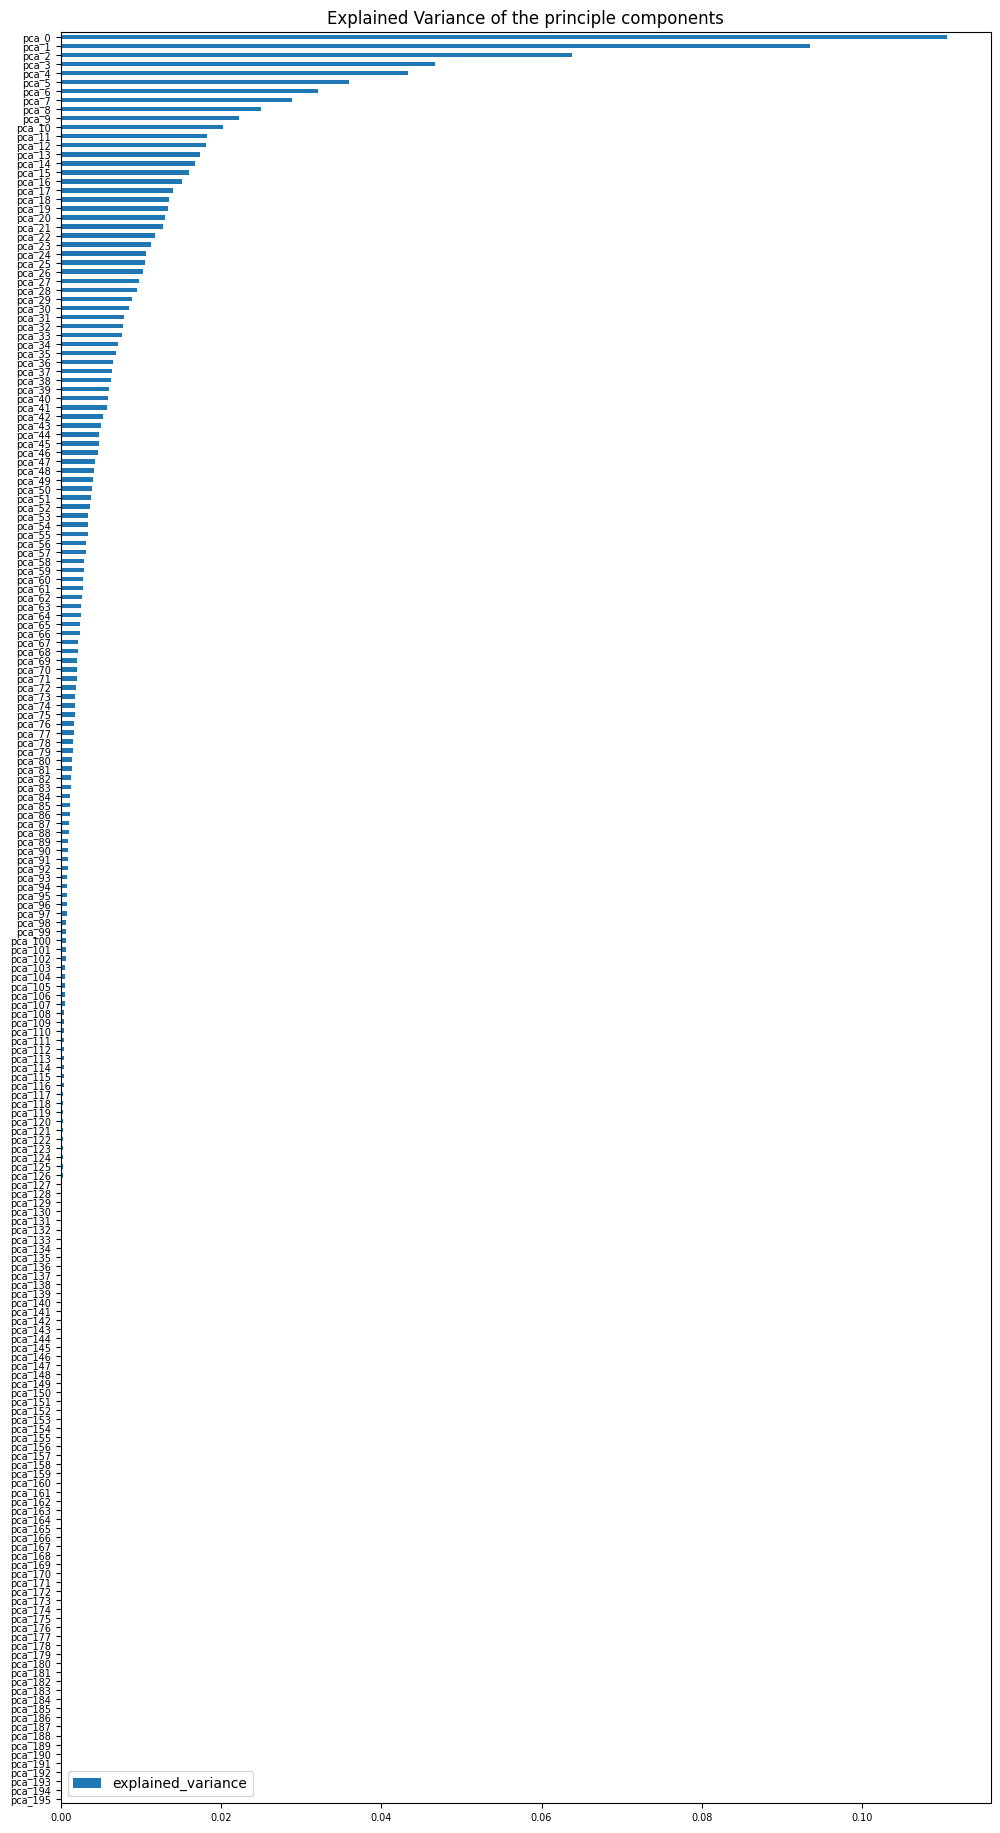

In [558]:
exp_var[::-1].plot(kind='barh', figsize=(12, 23), fontsize=7, title='Explained Variance of the principle components')

# Scaling the Dataset After The PCA transformation

In [559]:
pca_scaler = StandardScaler()

In [560]:
pca_train_df.loc[:, 'pca_0':] = pca_scaler.fit_transform(pca_train_df.loc[:, 'pca_0':])
pca_test_df.loc[:, 'pca_0':] = pca_scaler.transform(pca_test_df.loc[:, 'pca_0':])

dir_ = 'models/pca_scaler.pkl'
with open(dir_, 'wb') as file:
    pickle.dump(pca_scaler, file)

In [561]:
pca_train_df.to_csv(f'datasets/train_set_pca.csv')
pca_test_df.to_csv(f'datasets/test_set_pca.csv')

In [562]:
pca_train_df.describe().round(5)

,value,cpi_pct,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,...,pca_186,pca_187,pca_188,pca_189,pca_190,pca_191,pca_192,pca_193,pca_194,pca_195
count,497.00000,497.00000,497.00000,497.00000,497.00000,497.00000,497.00000,497.00000,497.00000,497.00000,...,497.00000,497.00000,497.00000,497.00000,497.00000,497.00000,497.00000,497.00000,497.00000,497.00000
mean,159.05416,0.00318,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,...,-0.00000,0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000
std,71.18925,0.00333,1.00101,1.00101,1.00101,1.00101,1.00101,1.00101,1.00101,1.00101,...,1.00101,1.00101,1.00101,1.00101,1.00101,1.00101,1.00101,1.00101,1.00101,1.00101
min,39.60000,-0.01786,-2.23113,-4.58016,-5.69774,-4.37224,-3.40061,-7.04036,-4.71155,-10.14257,...,-3.27515,-2.81446,-3.13460,-3.32049,-3.18251,-2.74405,-3.37700,-3.25605,-3.83859,-8.02806
25%,102.60000,0.00155,-0.54973,-0.43762,-0.39999,-0.54432,-0.50946,-0.37036,-0.46537,-0.31478,...,-0.65241,-0.59721,-0.59659,-0.66138,-0.60856,-0.63984,-0.59928,-0.66239,-0.62943,-0.36237
50%,160.40000,0.00266,-0.03488,0.10455,-0.11471,-0.06618,-0.08679,0.07341,0.01316,0.05726,...,-0.01718,-0.00504,-0.01284,-0.00846,0.02282,-0.01366,-0.04821,-0.02275,-0.03014,-0.01059
75%,219.03500,0.00461,0.74023,0.43058,0.30893,0.43021,0.38208,0.49974,0.54475,0.37001,...,0.62277,0.69681,0.65573,0.67061,0.59575,0.66623,0.64443,0.63372,0.71260,0.38469
max,307.91700,0.01794,4.28283,6.33547,7.19177,10.35691,8.86237,8.57933,6.82601,10.24010,...,3.62739,3.58915,4.58534,3.65263,4.03555,4.87022,4.80149,3.78395,4.06070,15.30942


In [563]:
# dont look at test data! its cheating
# pca_test_df.describe()

In [564]:
pca_components = pd.DataFrame(pca.components_, index=pca.feature_names_in_, columns=[f'pca_{i}' for i in range(pca.components_.shape[1])])
pca_components.to_csv('pca_components.csv', index=False)

In [565]:
pca_components.iloc[:, :5]

,pca_0,pca_1,pca_2,pca_3,pca_4
month,7.400279e-03,-0.002813,0.002813,-1.233000e-01,-2.307301e-02
jan-sep,-8.841350e-03,0.006560,-0.006560,-5.353674e-02,-6.266447e-02
oct-dec,1.015460e-02,0.005552,-0.005552,5.223964e-02,1.079565e-01
cpi_lag1,-2.590817e-02,0.039726,-0.039726,1.005350e-01,7.094441e-02
cpi_3ema,2.296947e-02,-0.030689,0.030689,-1.143760e-02,-6.420835e-02
...,...,...,...,...,...
gdp_9m_pct,-2.124664e-04,0.000059,-0.000059,-1.991705e-02,4.343115e-04
gdp_3m_pct_6m_lag,1.520238e-04,0.000152,-0.000152,-1.624799e-02,8.874425e-03
gdp_9m_pct_9m_lag,-2.944374e-04,-0.000283,0.000283,8.630484e-02,-8.427119e-03
gdp_24ma,-6.043687e-05,0.000033,-0.000033,3.336930e-02,-4.450654e-03
